In [1]:
"""
tutorial.py - This notebook is a walkthrough for some of QOC's functionality.

This tutorial will follow the experimental setup of [1].
All frequencies are in gigahertz. All time scales are in nanoseconds.

References:
[0] https://qoc.readthedocs.io/en/latest/ (coming soon)
[1] https://arxiv.org/abs/1608.02430
[2] https://github.com/HIPS/autograd
[3] https://en.wikipedia.org/wiki/Automatic_differentiation
[4] https://en.wikipedia.org/wiki/Lindbladian
[5] http://docs.h5py.org/en/stable/
[6] https://filelock.readthedocs.io/en/latest/
"""

import os

# Every computation that qoc performs has to be differentiable.
# qoc uses autograd [2] to do automatic differentiation [3].
# All operations that you perform on your operands should use autograd's
# numpy wrapper. autograd.numpy wraps the entire numpy namespace, but not all functions
# have derivatives implemented for them. You may view which functionality is supported
# on autograd's github [2].
import autograd.numpy as anp

# All of the core functionality that qoc offers can be imported from the top level.
# Core functionality not shown here includes `evolve_schroedinger_discrete`
# and `evolve_lindblad_discrete`.
from qoc import (grape_schroedinger_discrete, grape_lindblad_discrete)

# qoc.standard is a module that has optimization cost functions, optimizers,
# convenience functions, and other goodies. All of the operations
# (e.g. `conjugate_transpose`) that you import
# from qoc.standard use autograd.numpy, so they are OK to use in your operations.
from qoc.standard import (Adam,
    conjugate_transpose, generate_save_file_path,
    get_creation_operator, get_annihilation_operator,
    krons, LBFGSB, matmuls, plot_controls, plot_density_population,
    plot_state_population, TargetDensityInfidelity,
    TargetStateInfidelity,)

 /Users/apple/miniconda3/envs/python36/lib/python3.6/site-packages/IPython/html.py: 14

In [2]:
# First, we define our experimental constants as in [1] pp.7.
PI_2 = 2 * anp.pi
W_T = PI_2 * 5.6640 #GHz
W_C = PI_2 * 4.4526
CHI = PI_2 * -2.194
ALPHA_BY_2 = PI_2 * -2.36e-1
KAPPA_BY_2 = PI_2 * -3.7e-6
CHIP_BY_2 = PI_2 * -1.9e-6
T1_T = 1.7e5 #ns
TP_T = 4.3e4
T1_C = 2.7e6

# Second, we define the system.
CAVITY_STATE_COUNT = 2
TRANSMON_STATE_COUNT = 2
HILBERT_SIZE = CAVITY_STATE_COUNT * TRANSMON_STATE_COUNT
A = get_annihilation_operator(CAVITY_STATE_COUNT)
A_DAGGER = get_creation_operator(CAVITY_STATE_COUNT)
A_ID = anp.eye(CAVITY_STATE_COUNT)
# Notice how the state vectors are specified as column vectors.
CAVITY_VACUUM = anp.zeros((CAVITY_STATE_COUNT, 1))
CAVITY_ZERO = anp.copy(CAVITY_VACUUM)
CAVITY_ZERO[0, 0] = 1
CAVITY_ONE = anp.copy(CAVITY_VACUUM)
CAVITY_ONE[1, 0] = 1
B = get_annihilation_operator(TRANSMON_STATE_COUNT)
B_DAGGER = get_creation_operator(TRANSMON_STATE_COUNT)
B_ID = anp.eye(TRANSMON_STATE_COUNT)
TRANSMON_VACUUM = anp.zeros((TRANSMON_STATE_COUNT, 1))
TRANSMON_ZERO = anp.copy(TRANSMON_VACUUM)
TRANSMON_ZERO[0, 0] = 1
TRANSMON_ONE = anp.copy(TRANSMON_VACUUM)
TRANSMON_ONE[1, 0] = 1

# Next, we define the system hamiltonian.
# qoc requires you to specify your hamiltonian as a function of control parameters
# and time, i.e.
# hamiltonian_function :: (controls :: ndarray (control_count),
#                          time :: float)
#                          -> hamiltonian_matrix :: ndarray (hilbert_size x hilbert_size)
# You will see this notation in the qoc documentation. The symbol `::` is read "as".
# It specifies the object type of the argument. E.g. 1 :: int, True :: bool, 'hello' :: str.
# The parens that follow the `ndarray` type specifies the shape of the array.
# E.g. anp.array([[1, 2], [3, 4]]) :: ndarray (2 x 2)
# Control parameters are values that you will use to vary time-dependent control fields
# that act on your system. Note that qoc supports both complex and real control parameters.
# In this case, we are controlling a charge drive on the cavity, and a charge drive on the transmon.
# Each drive is parameterized by a single, complex control parameter.
SYSTEM_HAMILTONIAN = (W_C * krons(matmuls(A_DAGGER, A), B_ID)
                      + KAPPA_BY_2 * krons(matmuls(A_DAGGER, A_DAGGER, A , A), B_ID)
                      + W_T * krons(A_ID, matmuls(B_DAGGER, B))
                      + ALPHA_BY_2 * krons(A_ID, matmuls(B_DAGGER, B_DAGGER, B, B))
                      + CHI * krons(matmuls(A_DAGGER, A), matmuls(B_DAGGER, B))
                      + CHIP_BY_2 * krons(matmuls(B_DAGGER, B), matmuls(A_DAGGER, A_DAGGER, A, A)))
CONTROL_0 = krons(A, B_ID)
CONTROL_0_DAGGER = krons(A_DAGGER, B_ID)
CONTROL_1 = krons(A_ID, B)
CONTROL_1_DAGGER = krons(A_ID, B_DAGGER)
def hamiltonian(controls, time):
    return (SYSTEM_HAMILTONIAN
            + controls[0] * CONTROL_0
            + anp.conjugate(controls[0]) * CONTROL_0_DAGGER
            + controls[1] * CONTROL_1
            + anp.conjugate(controls[1]) * CONTROL_1_DAGGER)

# Additionally, we need to specify information to qoc about...
# how long our system will evolve for
EVOLUTION_TIME = 15 #ns
# how many controls we have
CONTROL_COUNT = 2
# what domain our controls are in
COMPLEX_CONTROLS = True
# where our controls are positioned in time
CONTROL_EVAL_COUNT = int(1e2)
# and where our system is evaluated in time
SYSTEM_EVAL_COUNT = int(1e2)
# Note that `CONTROL_COUNT` is the length of the `controls` array that is passed
# to our `hamiltonian` function.
# `CONTROL_EVAL_COUNT` is used to determine how many points in time the `controls` are
# evaluated. It is likely this value should be consistent with a physical apparatus,
# such as the sampling rate of an AWG. The points in time where controls are evaluated
# is given by control_eval_times = anp.linspace(0, evolution_time, control_eval_count).
# Note that qoc uses an interpolation method to interpolate the control parameters
# between these time points. You can change this behavior using the
# `interpolation_policy` argument.
# SYSTEM_EVAL_COUNT is used to determine the update step of the evolution.
# Similarly, system_eval_times = anp.linspace(0, evolution_time, system_eval_count).
# Two important things happen at each system_eval step.
# First, cost functions that are computed multiple times throughout
# the evolution (as opposed to those only computed at the end of evolution)
# are evaluated at system_eval steps. You can change this behavior using the
# `cost_eval_step` argument. Second, qoc uses an exponential series method
# to integrate the schroedinger equation. `system_eval_times` specifies the
# time steps used in this integration. Therefore, increasing the `system_eval_count`
# will likely increase the accuracy of the evolution. The accuracy of the evolution
# can also be increased with the `magnus_policy` argument. Increasing the accuracy
# using both of these methods will increase the computational cost.
# Note that qoc does not use an exponential series method to integrate the lindblad
# equation. Therefore, increasing the `system_eval_count` for lindblad methods
# will not increase the accuracy of their evolution.

# Now, we are ready to give qoc a problem.
# Let's try to put a photon in the cavity.
# That is, we desire the fock state transition |0, g> -> |1, g>.
INITIAL_STATE_0 = krons(CAVITY_ZERO, TRANSMON_ZERO)
# Notice that when we specify states (or probability density matrices!)
# to qoc, we always give qoc an array of states that we would like it to track,
# even if we only give qoc a single state. The `,` in anp.stack((INITIAL_STATE_0`,`))
# makes a difference.
INITIAL_STATES = anp.stack((INITIAL_STATE_0,))
assert(INITIAL_STATES.ndim == 3)
TARGET_STATE_0 = krons(CAVITY_ONE, TRANSMON_ZERO)
TARGET_STATES = anp.stack((TARGET_STATE_0,))
# Costs are functions that we want qoc to minimize the output of.
# In this example, we want to minimize the infidelity (maximize the fidelity) of
# the initial state and the target state.
# Note that `COSTS` is a list of cost function objects.
COSTS = [TargetStateInfidelity(TARGET_STATES)]

# We want to tell qoc how often to store information about the optimization
# and how often to log output. Both `log_iteration_step` and `save_iteration_step`
# are specified in units of optimization iterations.
LOG_ITERATION_STEP = 1
SAVE_INTERMEDIATE_STATES = True
SAVE_ITERATION_STEP = 1

# For this problem, the LBFGSB optimizer reaches a reasonable
# answer very quickly.
OPTIMIZER = LBFGSB()
ITERATION_COUNT = 20
# In practice, we find that using a second-order optimizer, such as LBFGSB,
# gives a good initial answer. Then, this answer may be used with a first-
# order optimizer, such as Adam, to achieve the desired error.
# You can seed optimizations with a set of controls using the
# `initial_controls` argument.

In [3]:
# Before we move on, it is a good idea to check that everything looks how you would expect it to.
print("HILBERT_SIZE:\n{}"
      "".format(HILBERT_SIZE))
print("SYSTEM_HAMILTONIAN:\n{}"
      "".format(SYSTEM_HAMILTONIAN))
print("CAVITY_ZERO:\n{}"
      "".format(CAVITY_ZERO))
print("CAVITY_ONE:\n{}"
      "".format(CAVITY_ONE))
print("TRANSMON_ZERO:\n{}"
      "".format(TRANSMON_ZERO))
print("TRANSMON_ONE:\n{}"
      "".format(TRANSMON_ONE))
print("INITIAL_STATE_0:\n{}"
      "".format(INITIAL_STATE_0))
print("TARGET_STATE_0:\n{}"
      "".format(TARGET_STATE_0))
print("CONTROL_EVAL_TIMES:\n{}"
      "".format(anp.linspace(0, EVOLUTION_TIME, CONTROL_EVAL_COUNT)))
print("SYSTEM_EVAL_TIMES:\n{}"
      "".format(anp.linspace(0, EVOLUTION_TIME, SYSTEM_EVAL_COUNT)))

HILBERT_SIZE:
4
SYSTEM_HAMILTONIAN:
[[ 0.          0.          0.          0.        ]
 [ 0.         35.58796158  0.          0.        ]
 [ 0.          0.         27.9765109   0.        ]
 [ 0.          0.          0.         49.77916391]]
CAVITY_ZERO:
[[1.]
 [0.]]
CAVITY_ONE:
[[0.]
 [1.]]
TRANSMON_ZERO:
[[1.]
 [0.]]
TRANSMON_ONE:
[[0.]
 [1.]]
INITIAL_STATE_0:
[[1.]
 [0.]
 [0.]
 [0.]]
TARGET_STATE_0:
[[0.]
 [0.]
 [1.]
 [0.]]
CONTROL_EVAL_TIMES:
[ 0.          0.15151515  0.3030303   0.45454545  0.60606061  0.75757576
  0.90909091  1.06060606  1.21212121  1.36363636  1.51515152  1.66666667
  1.81818182  1.96969697  2.12121212  2.27272727  2.42424242  2.57575758
  2.72727273  2.87878788  3.03030303  3.18181818  3.33333333  3.48484848
  3.63636364  3.78787879  3.93939394  4.09090909  4.24242424  4.39393939
  4.54545455  4.6969697   4.84848485  5.          5.15151515  5.3030303
  5.45454545  5.60606061  5.75757576  5.90909091  6.06060606  6.21212121
  6.36363636  6.51515152  6.66666667  6.

In [4]:
# qoc saves data in h5 format. You can parse h5 files using the `h5py` package [5].
EXPERIMENT_NAME = "tutorial_schroed_cavity01"
SAVE_PATH = "./out"
SCHROED_FILE_PATH = generate_save_file_path(EXPERIMENT_NAME, SAVE_PATH)

# Next, we use the GRAPE algorithm to find a set of time-dependent
# controls that accomplishes the state transfer that we desire.
result = grape_schroedinger_discrete(CONTROL_COUNT,
                                     CONTROL_EVAL_COUNT,
                                     COSTS, EVOLUTION_TIME,
                                     hamiltonian, INITIAL_STATES,
                                     SYSTEM_EVAL_COUNT,
                                     complex_controls=COMPLEX_CONTROLS,
                                     iteration_count=ITERATION_COUNT,
                                     log_iteration_step=LOG_ITERATION_STEP,
                                     optimizer=OPTIMIZER,
                                     save_file_path=SCHROED_FILE_PATH,
                                     save_intermediate_states=SAVE_INTERMEDIATE_STATES,
                                     save_iteration_step=SAVE_ITERATION_STEP,)

iteration_count: 20
QOC is saving this optimization run to ./out/00013_tutorial_schroed_cavity01.h5.
iter   |   total error  |    grads_l2   
  0    | 9.99980846e-01 | 6.91109703e-03
  1    | 9.03665103e-01 | 4.65906180e-01
  2    | 9.99941476e-01 | 1.20802937e-02
  3    | 9.99850738e-01 | 1.92913917e-02
  4    | 9.99419404e-01 | 3.80388730e-02
  5    | 9.98849747e-01 | 5.35256367e-02
  6    | 9.92219992e-01 | 1.38742757e-01
  7    | 9.91538351e-01 | 1.44644401e-01
  8    | 4.67491649e-01 | 7.87974888e-01
  9    | 9.43572061e-01 | 3.64390733e-01
  10   | 9.28538183e-01 | 4.06792124e-01
  11   | 1.80536530e-03 | 6.67876738e-02
  12   | 2.30499517e-02 | 2.37244813e-01
  13   | 2.30548597e-03 | 7.55476925e-02
  14   | 1.85386201e-03 | 6.76872166e-02
  15   | 1.81057195e-03 | 6.68848336e-02
  16   | 1.80593029e-03 | 6.67982239e-02
  17   | 1.80542668e-03 | 6.67888200e-02
  18   | 1.80537197e-03 | 6.67877984e-02
  19   | 1.80536603e-03 | 6.67876873e-02


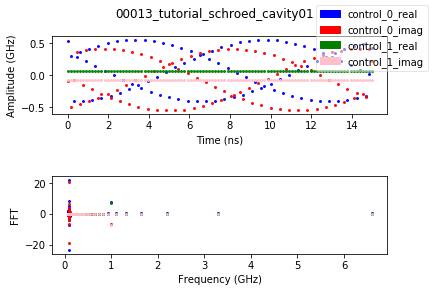

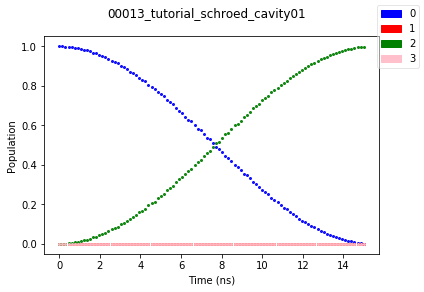

In [5]:
# Next, we want to do some analysis of our results.
CONTROLS_PLOT_FILE = "{}_controls.png".format(EXPERIMENT_NAME)
CONTROLS_PLOT_FILE_PATH = os.path.join(SAVE_PATH, CONTROLS_PLOT_FILE)
POPULATION_PLOT_FILE = "{}_population.png".format(EXPERIMENT_NAME)
POPULATION_PLOT_FILE_PATH = os.path.join(SAVE_PATH, POPULATION_PLOT_FILE)
SHOW = True
# This function will plot the controls, and their fourier transform.
plot_controls(SCHROED_FILE_PATH,
              save_file_path=CONTROLS_PLOT_FILE_PATH,
              show=SHOW,)
# This function will plot the values of the diagonal elements of the
# density matrix that is formed by taking the outer product of the state
# with itself.
plot_state_population(SCHROED_FILE_PATH,
                      save_file_path=POPULATION_PLOT_FILE_PATH,
                      show=SHOW,)
# Both of the above functions plot the iteration that achieved the lowest error
# by default. However, you check out their documentation in the source or
# on qoc's documentation [0] to plot arbitrary iterations.
# QOC locks [6] every h5 file before it writes to it or reads from it.
# Therefore, you can call these plotting functions from a seperate process
# while your optimization is running to see the current controls
# or the current population diagrams.

In [ ]:
# Great, we have now obtained a control pulse that will achieve a desired
# state transfer for a closed quantum system. If we want to model an open quantum system,
# qoc also gives us the power to do that. In particular, qoc chooses to model
# dissipative systems using the lindblad master equation [4].
# Similar to the way we defined our hamiltonian, we define our lindblad operators
# and dissipation constants as a joint function of time.
# lindblad_data :: (time :: float)
# -> (dissipators :: ndarray (lindblad_operator_count),
#     operators :: ndarray (lindblad_operator_count x hilbert_size x hilbert_size))
# The operators defined here follow from e.q. 9 of [1].
L_OP_0 = krons(A, B_ID)
L_OP_1 = krons(A_ID, B)
L_OP_2 = krons(A_ID, matmuls(B_DAGGER, B))
G_0 = 1 / T1_C
G_1 = 1 / T1_T
G_2 = 1 / TP_T
LINDBLAD_DISSIPATORS = anp.array((G_0, G_1, G_2,))
LINDBLAD_OPERATORS = anp.stack((L_OP_0, L_OP_1, L_OP_2,))
lindblad_data = lambda time: (LINDBLAD_DISSIPATORS, LINDBLAD_OPERATORS)

# Notice that the lindblad equation operates on density matrices; it does not operate on state vectors
# like the schroedinger equation.
# Therefore, we need to redefine the initial state of our system, and our cost functions,
# using density matrices.
INITIAL_DENSITIES = matmuls(INITIAL_STATES, conjugate_transpose(INITIAL_STATES))
TARGET_DENSITIES = matmuls(TARGET_STATES, conjugate_transpose(TARGET_STATES))
COSTS = [TargetDensityInfidelity(TARGET_DENSITIES)]

# As mentioned earlier, the `system_eval_count` argument has no bearing on
# the accuracy of the lindblad integrator. Therefore, if you do not have any cost
# functions that require evaluation at intermediary time steps in the evolution,
# it is recommended that you set `system_eval_count` = 2.
# This means that the lindblad integrator will only evaluate the density matrices
# at time=0 and time=EVOLUTION_TIME.
SYSTEM_EVAL_COUNT = 2
SAVE_INTERMEDIATE_DENSITIES = True

In [ ]:
# TODO: This optimization does not converge, and it is slow.
# Either tweak the parameters to get the optimization to converge,
# or consider demonstrating a different example.
# For a working lindblad example, check out `examples/1_transmon_pi_decoherence.py`
EXPERIMENT_NAME = "tutorial_lindblad_cavity01"
LINDBLAD_FILE_PATH = generate_save_file_path(EXPERIMENT_NAME, SAVE_PATH)
result = grape_lindblad_discrete(CONTROL_COUNT,
                                 CONTROL_EVAL_COUNT,
                                 COSTS, EVOLUTION_TIME,
                                 INITIAL_DENSITIES,
                                 SYSTEM_EVAL_COUNT,
                                 complex_controls=COMPLEX_CONTROLS,
                                 hamiltonian=hamiltonian,
                                 lindblad_data=lindblad_data,
                                 log_iteration_step=LOG_ITERATION_STEP,
                                 optimizer=OPTIMIZER,
                                 save_file_path=LINDBLAD_FILE_PATH,
                                 save_intermediate_densities=SAVE_INTERMEDIATE_DENSITIES,
                                 save_iteration_step=SAVE_ITERATION_STEP,)

In [ ]:
# Again, we want to analyze our results.
L_CONTROLS_PLOT_FILE = "{}_controls.png".format(EXPERIMENT_NAME)
L_CONTROLS_PLOT_FILE_PATH = os.path.join(SAVE_PATH, L_CONTROLS_PLOT_FILE)
L_POPULATION_PLOT_FILE = "{}_population.png".format(EXPERIMENT_NAME)
L_POPULATION_PLOT_FILE_PATH = os.path.join(SAVE_PATH, L_POPULATION_PLOT_FILE)
SHOW = True
plot_controls(LINDBLAD_FILE_PATH,
              save_file_path=L_CONTROLS_PLOT_FILE_PATH,
              show=SHOW,)
plot_density_population(LINDBLAD_FILE_PATH,
                        save_file_path=L_POPULATION_PLOT_FILE_PATH,
                        show=SHOW,)